# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,StratifiedKFold,KFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix ,recall_score,precision_score,f1_score

In [27]:
df = pd.read_csv('data/bank-additional-full.csv', sep=';')

In [28]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [29]:
print('='*100 + '\n')
df.info()
print('='*100 + '\n')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null

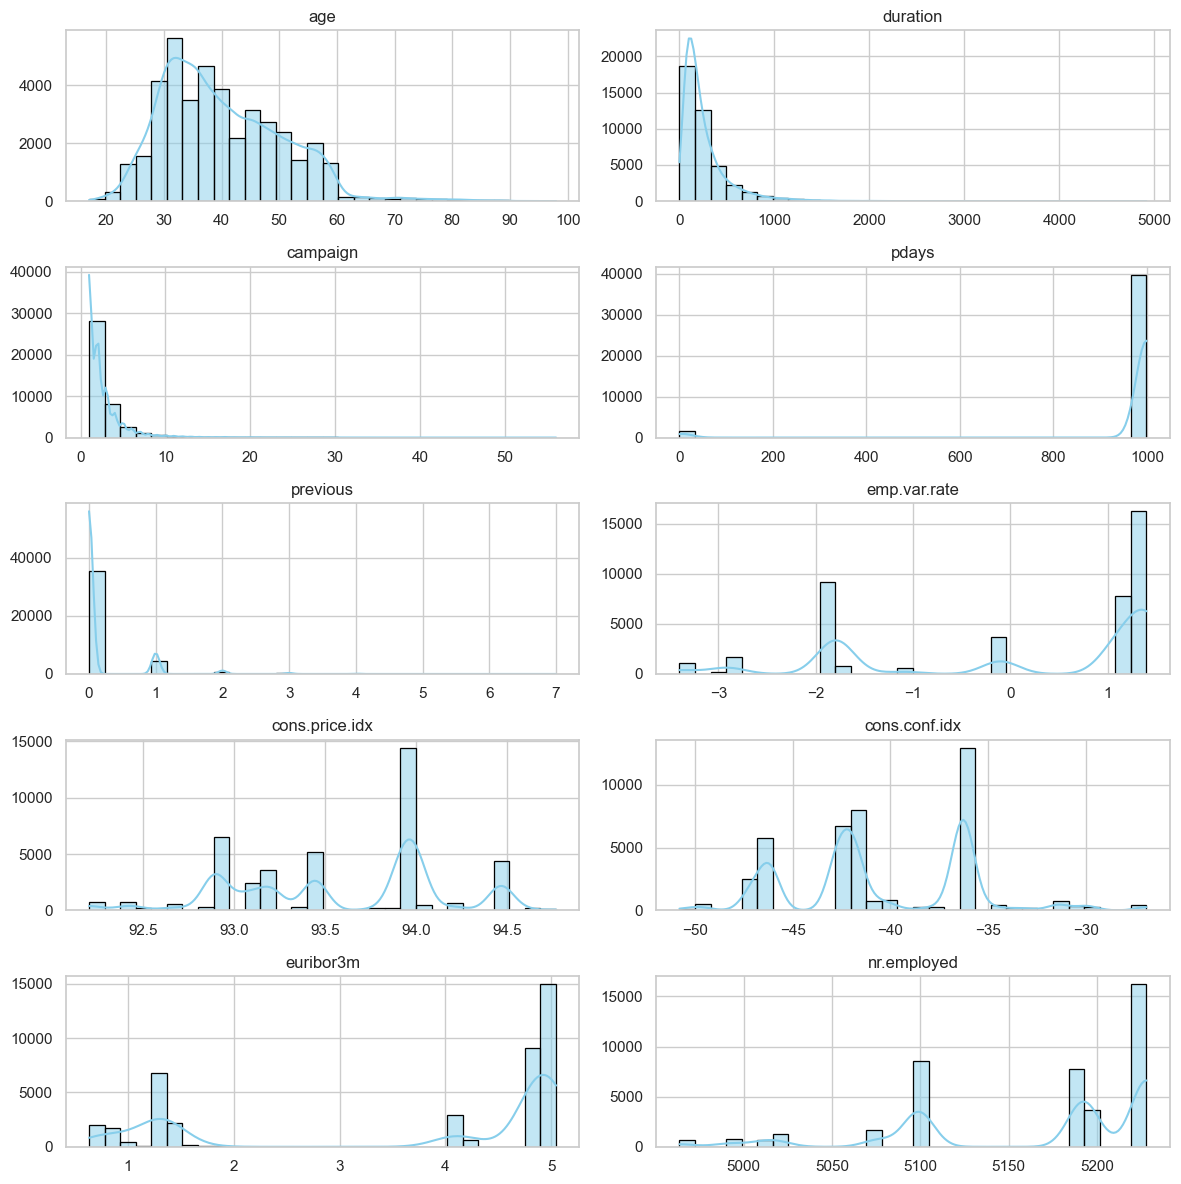

In [30]:
print('='*100 + '\n')
#For the Numeric columns study the distribution , check for outliers 
numeric_columns = ['age', 'duration', 'campaign', 'pdays', 'previous', 
                   'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 
                   'euribor3m', 'nr.employed']

# Plot histograms
plt.figure(figsize=(12, 12))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(5, 2, i)
    sns.histplot(df[col], bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(True)

plt.tight_layout()
plt.show()

print('='*100 + '\n')

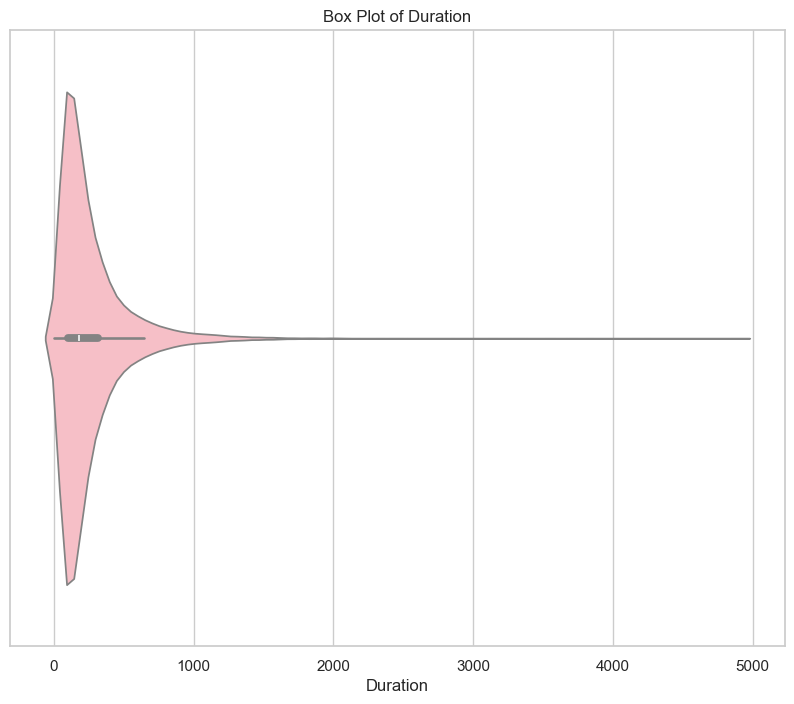

In [31]:
# Set plot size
plt.figure(figsize=(10, 8))

sns.violinplot(x=df['duration'], color='lightpink')
plt.title('Box Plot of Duration')
plt.xlabel('Duration')
plt.show()
print('='*100 + '\n')

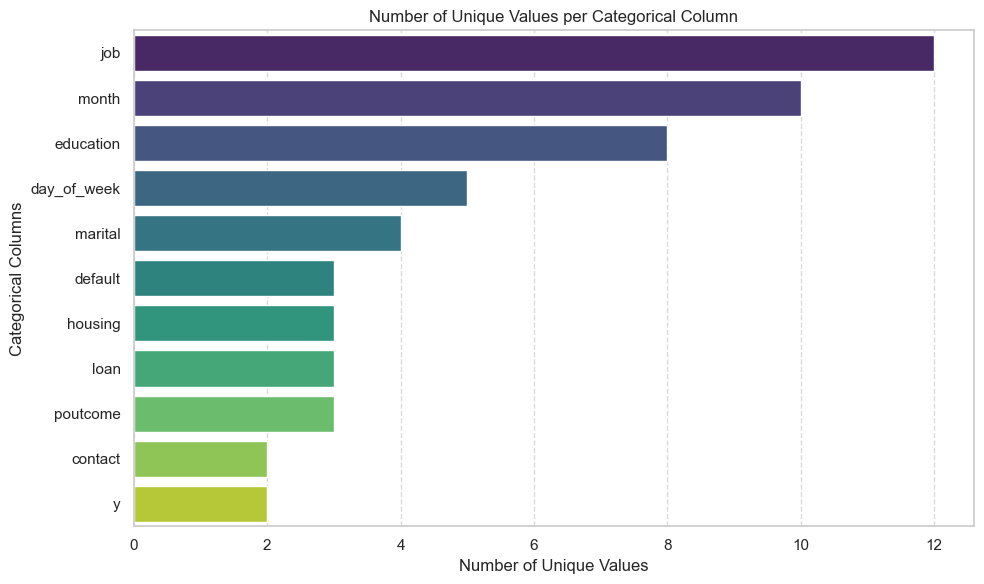

In [32]:
# For categorical columns ,find distinct values to decide on feature encoding
categorical_columns = df.select_dtypes(include='object').columns

# Count unique values in each categorical column
unique_counts = df[categorical_columns].nunique().sort_values(ascending=False)

# Plot the unique value counts
plt.figure(figsize=(10, 6))
sns.barplot(x=unique_counts.values, y=unique_counts.index, palette='viridis' ,hue=unique_counts.index)
plt.title('Number of Unique Values per Categorical Column')
plt.xlabel('Number of Unique Values')
plt.ylabel('Categorical Columns')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print('='*100 + '\n')



--- Value Counts for 'job' ---
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64


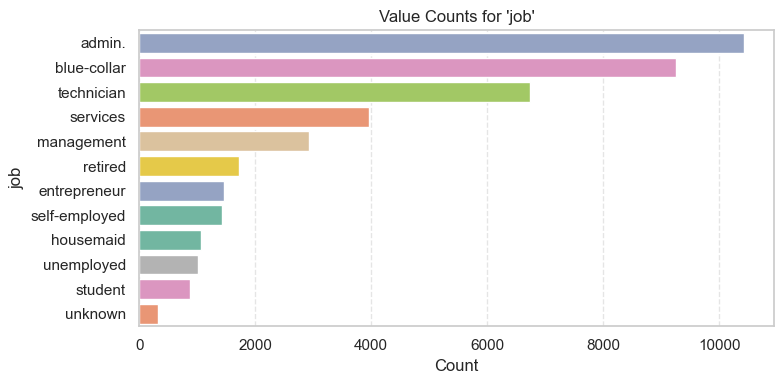



--- Value Counts for 'marital' ---
marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64


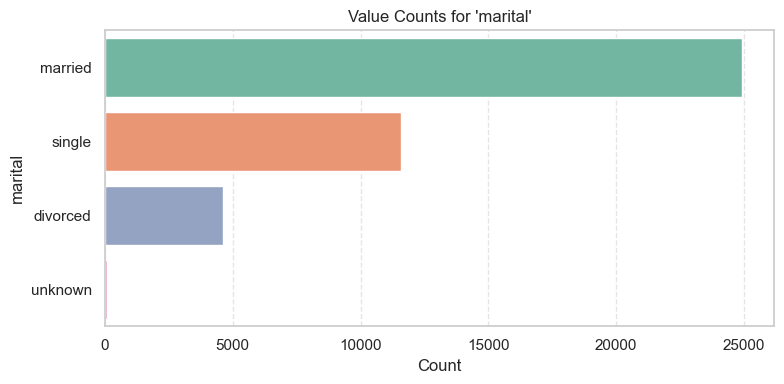



--- Value Counts for 'education' ---
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64


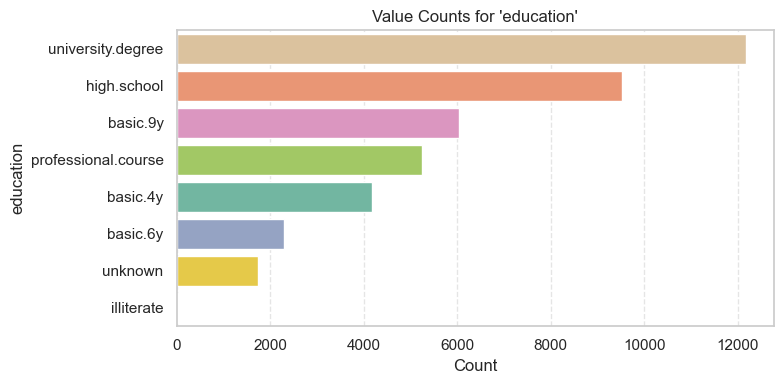



--- Value Counts for 'default' ---
default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64


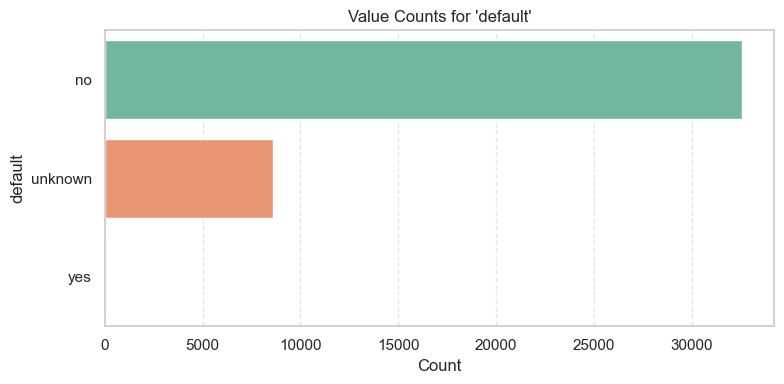



--- Value Counts for 'housing' ---
housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64


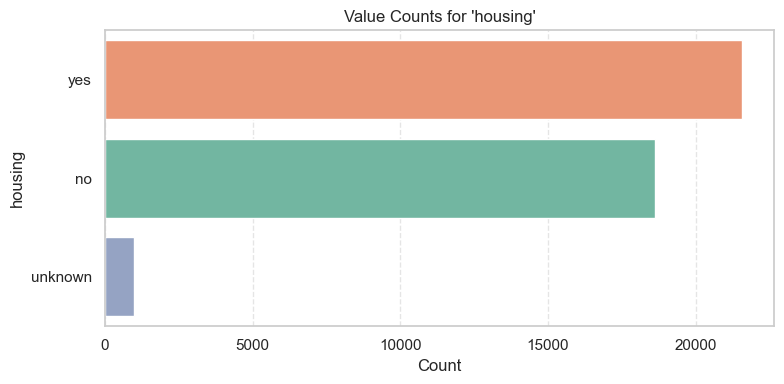



--- Value Counts for 'loan' ---
loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64


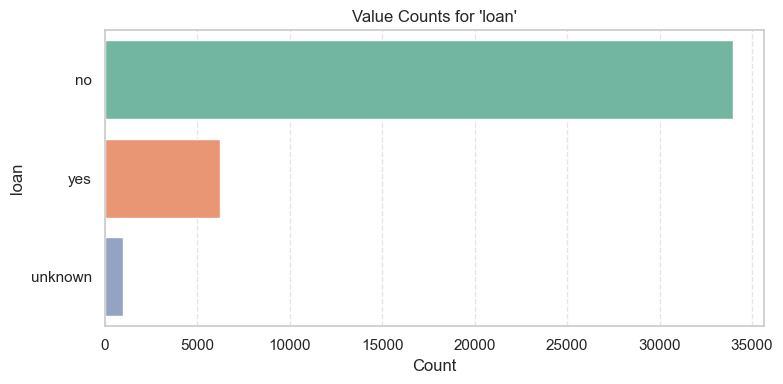



--- Value Counts for 'contact' ---
contact
cellular     26144
telephone    15044
Name: count, dtype: int64


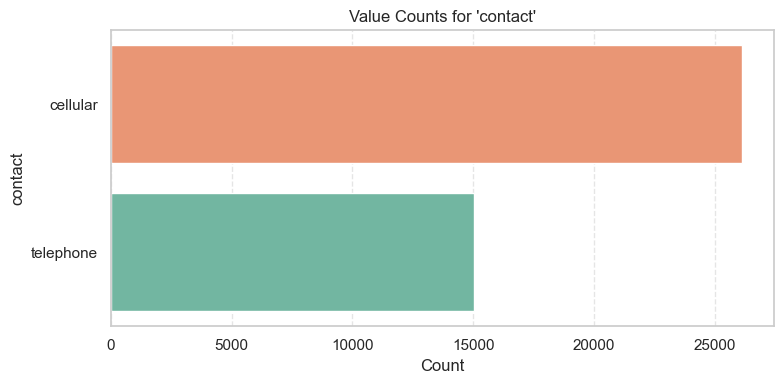



--- Value Counts for 'month' ---
month
may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: count, dtype: int64


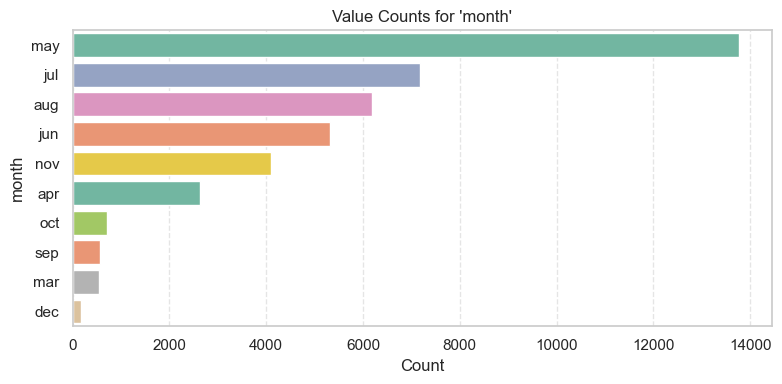



--- Value Counts for 'day_of_week' ---
day_of_week
thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: count, dtype: int64


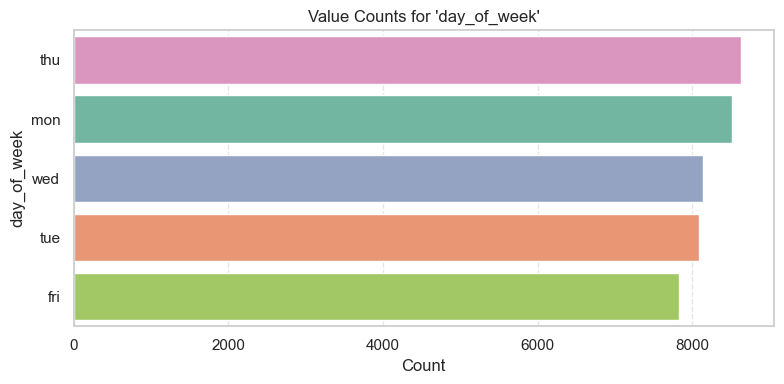



--- Value Counts for 'poutcome' ---
poutcome
nonexistent    35563
failure         4252
success         1373
Name: count, dtype: int64


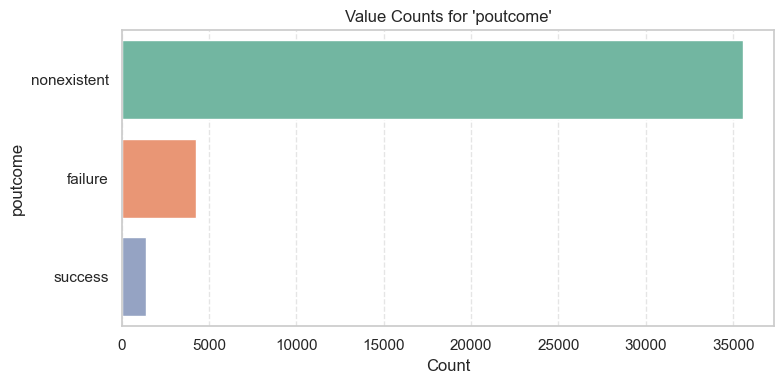



--- Value Counts for 'y' ---
y
no     36548
yes     4640
Name: count, dtype: int64


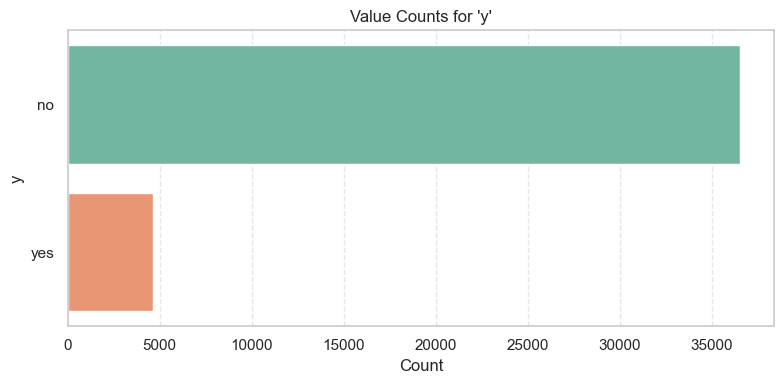

In [33]:
print('='*100 + '\n')
for col in categorical_columns:
  
    print(f"\n--- Value Counts for '{col}' ---")
    print(df[col].value_counts())
    
    
    # Plotting value counts
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, y=col, order=df[col].value_counts().index, palette='Set2' ,hue=col)
    plt.title(f"Value Counts for '{col}'")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    print('='*100 + '\n')

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [34]:

categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('y')  

# One-hot encode only categorical columns
X_cat_encoded = pd.get_dummies(df[categorical_columns], drop_first=True)

# Combine numeric columns with encoded categorical columns
X_final = pd.concat([df[numeric_columns], X_cat_encoded], axis=1)

y_encoded = df['y'].map({'no':0, 'yes':1})
df_corr = pd.concat([X_final, y_encoded.rename('target')], axis=1)

In [35]:
'''
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('y')  

# One-hot encode only categorical columns
X_cat_encoded = pd.get_dummies(df[categorical_columns])

# Combine numeric columns with encoded categorical columns
X_final = pd.concat([df[numeric_columns], X_cat_encoded], axis=1)

y_encoded = df['y'].map({'no':0, 'yes':1})
df_corr = pd.concat([X_final, y_encoded.rename('target')], axis=1)'''

"\ncategorical_columns = df.select_dtypes(include=['object']).columns.tolist()\ncategorical_columns.remove('y')  \n\n# One-hot encode only categorical columns\nX_cat_encoded = pd.get_dummies(df[categorical_columns])\n\n# Combine numeric columns with encoded categorical columns\nX_final = pd.concat([df[numeric_columns], X_cat_encoded], axis=1)\n\ny_encoded = df['y'].map({'no':0, 'yes':1})\ndf_corr = pd.concat([X_final, y_encoded.rename('target')], axis=1)"

In [36]:
print('='*100 + '\n')
df_corr.info()
print('='*100 + '\n')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   duration                       41188 non-null  int64  
 2   campaign                       41188 non-null  int64  
 3   pdays                          41188 non-null  int64  
 4   previous                       41188 non-null  int64  
 5   emp.var.rate                   41188 non-null  float64
 6   cons.price.idx                 41188 non-null  float64
 7   cons.conf.idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr.employed                    41188 non-null  float64
 10  job_blue-collar                41188 non-null  bool   
 11  job_entrepreneur               41188 non-null  bool   
 12  job_housemaid                  41188 non-null

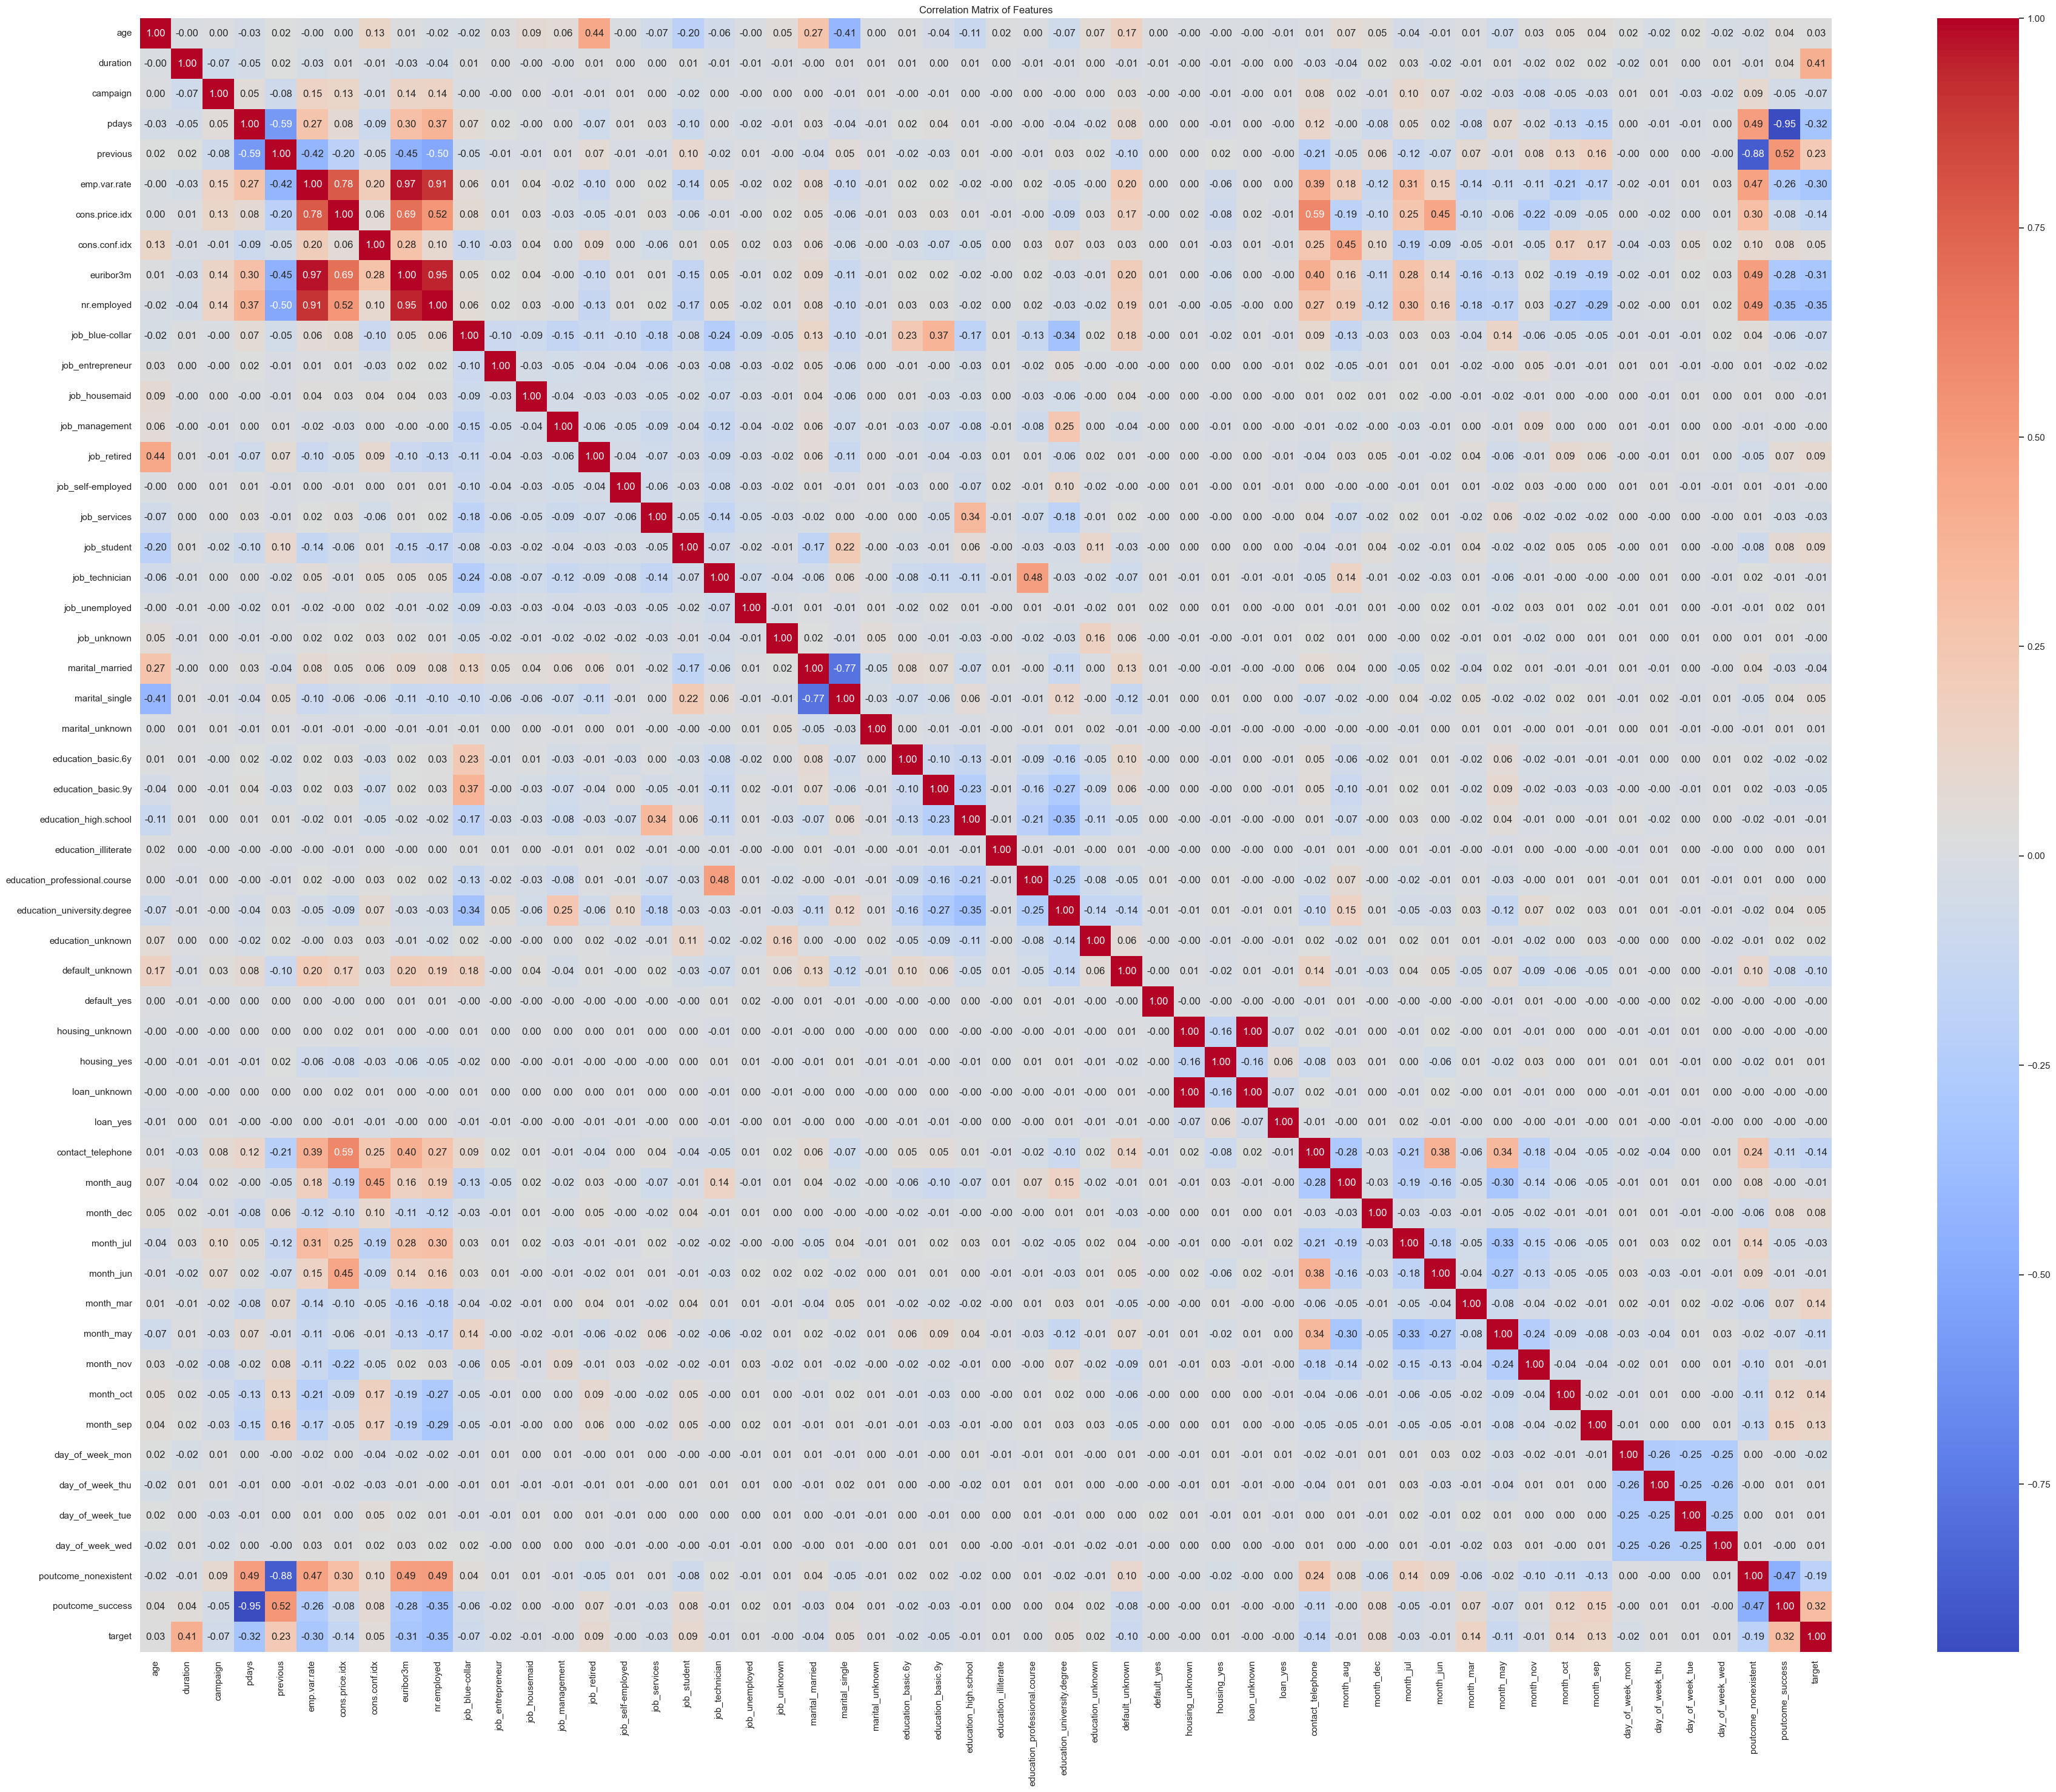

In [37]:
plt.figure(figsize=(45, 35))
print('='*100 + '\n')
# Plot heatmap  
sns.heatmap(df_corr.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Matrix of Features')
plt.show()

print('='*100 + '\n')

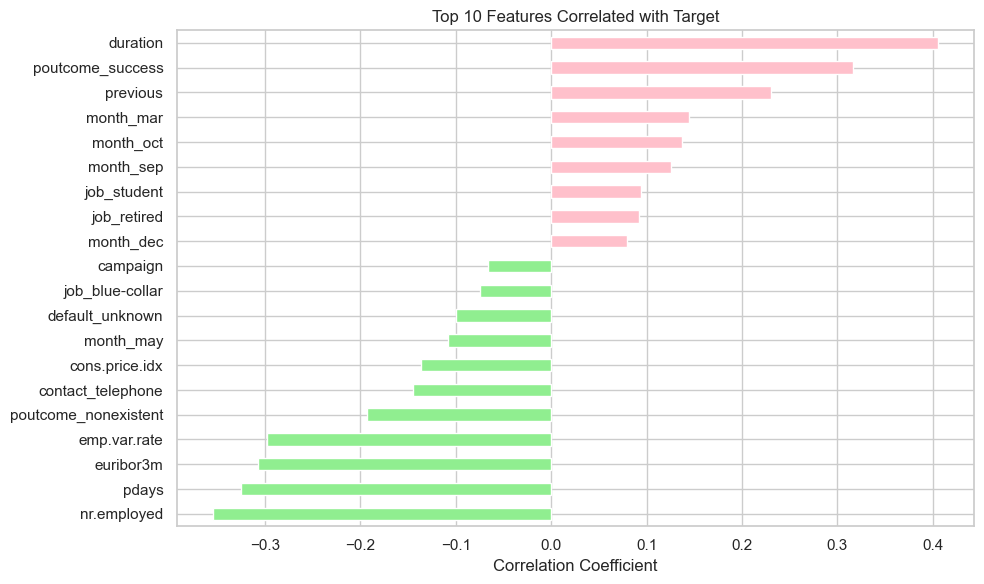

In [38]:
#  Correlation of features with target

correlations = df_corr.corr()['target'].drop('target')   

#  Select top 10 by absolute value 
top_features = correlations.abs().sort_values(ascending=False).head(20).index
top_10_corr = correlations[top_features]   

print('='*100 + '\n')

top_10_corr = top_10_corr.sort_values()
colors = ['pink' if val > 0 else 'lightgreen' for val in top_10_corr]

plt.figure(figsize=(10, 6))
top_10_corr.sort_values().plot(kind='barh', color=colors)
plt.title('Top 10 Features Correlated with Target')
plt.xlabel('Correlation Coefficient')
plt.grid(True)
plt.tight_layout()
plt.show()

print('='*100 + '\n')

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [39]:

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [40]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

# Baseline accuracy
baseline_accuracy = accuracy_score(y_test, y_pred_dummy)
print('='*100 + '\n')
print("Baseline accuracy (most frequent class):", baseline_accuracy)
print('='*100 + '\n')



Baseline accuracy (most frequent class): 0.8873512988589464



### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [41]:
log_reg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=1000, random_state=42))
])


log_reg_pipe.fit(X_train, y_train)


y_train_pred = log_reg_pipe.predict(X_train)
y_test_pred = log_reg_pipe.predict(X_test)


train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

### Problem 9: Score the Model

What is the accuracy of your model?

In [42]:
print('\n' + '='*100)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print('='*100 + '\n')



#  classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

print('='*100 + '\n')

#  confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print('='*100 + '\n')


Train Accuracy: 0.9100
Test Accuracy: 0.9164


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7310
           1       0.71      0.44      0.54       928

    accuracy                           0.92      8238
   macro avg       0.82      0.71      0.75      8238
weighted avg       0.91      0.92      0.91      8238


Confusion Matrix:
[[7145  165]
 [ 524  404]]



### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [43]:
# Pipeline 
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier())  
])

# Parameter grid for each classifier
param_grid = [
    {
        'clf': [KNeighborsClassifier()],
        'clf__n_neighbors': [3, 5, 7,10],
        'clf__weights': ['uniform', 'distance']
    },
    {
        'clf': [LogisticRegression(max_iter=1000, random_state=42)],
        'clf__C': [0.1, 1, 10],
        'clf__penalty': ['l2'],
        'clf__class_weight': ['balanced',None],
        'clf__solver': ['liblinear']
    },
    {
        'clf': [DecisionTreeClassifier(random_state=42)],
        'clf__max_depth': [None, 5, 10, 20],
        'clf__min_samples_split': [2, 5, 10],
        'clf__criterion': ['gini', 'entropy']
    },
    {
        'clf': [SVC(random_state=42)],
        'clf__C': [0.1, 1, 10],
        'clf__class_weight': ['balanced',None],
        'clf__kernel': ['linear', 'rbf'],
        'clf__gamma': ['scale', 'auto']
    }
]

# GridSearchCV setup
start_time = time.time()
cv_results_df=[]
results = []
param_performance_records = []

# Loop through each model's param grid
for grid in param_grid:
    model_name = type(grid['clf'][0]).__name__

    print('\n' + '='*100)
    print(f"\n Section Training: {model_name}")
    print('='*100 + '\n')
    
    gs = GridSearchCV(pipe, param_grid=grid, cv=5, 
                  scoring={'accuracy': 'accuracy', 'recall': 'recall'},
                  refit='recall',
                  n_jobs=-1, verbose=0)
    
    start = time.time()
    gs.fit(X_train, y_train)
    end = time.time()
    
    train_time = round(end - start, 2)
    
    cv_results_df = pd.DataFrame(gs.cv_results_)
    print(f"\n Average CV Accuracy , Recall by Parameter Value for {model_name}:")
    for param in grid:
        param_col = 'param_' + param
        if param_col in cv_results_df.columns:
            print(f"\n {param}")
            for val in cv_results_df[param_col].unique():
                if pd.isna(val):
                    label = 'None'
                    mask = pd.isna(cv_results_df[param_col])
                else:
                    label = val
                    mask = cv_results_df[param_col] == val
                mean_recall = cv_results_df.loc[mask, 'mean_test_recall'].mean()
                mean_accuracy = cv_results_df.loc[mask, 'mean_test_accuracy'].mean()

                print(f"    {label}: Recall (CV) = {mean_recall:.4f}, Accuracy (CV) = {mean_accuracy:.4f}")

                
                param_performance_records.append({
                    'Model': model_name,
                    'Parameter': param,
                    'Value': label,
                    'Mean CV Accuracy': round(mean_accuracy, 4),
                    'Mean CV Recall': round(mean_recall, 4)
                })
    
    best_model = gs.best_estimator_
    train_acc = accuracy_score(y_train, best_model.predict(X_train))
    test_acc = accuracy_score(y_test, best_model.predict(X_test))

    train_recall = recall_score(y_train, best_model.predict(X_train))
    test_recall = recall_score(y_test, best_model.predict(X_test))
    
    # Store results
    best_index = gs.best_index_  
    best_cv_accuracy = gs.cv_results_['mean_test_accuracy'][best_index]
    best_cv_recall = gs.cv_results_['mean_test_recall'][best_index]
    results.append({
        'Model': model_name,
        'Train Time (s)': train_time,
        'Train Accuracy': round(train_acc, 4),
        'Test Accuracy': round(test_acc, 4),
        'Train Recall': round(train_recall, 4),
        'Test Recall': round(test_recall, 4),
        'Best Params': gs.best_params_,
        'Best CV Accuracy': round(best_cv_accuracy, 4),
        'Best CV Recall': round(best_cv_recall, 4)
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
param_perf_df=pd.DataFrame(param_performance_records)
print('='*100 + '\n')



 Section Training: KNeighborsClassifier


 Average CV Accuracy , Recall by Parameter Value for KNeighborsClassifier:

 clf
    KNeighborsClassifier(): Recall (CV) = 0.2987, Accuracy (CV) = 0.8935

 clf__n_neighbors
    3: Recall (CV) = 0.3339, Accuracy (CV) = 0.8889
    5: Recall (CV) = 0.3072, Accuracy (CV) = 0.8930
    7: Recall (CV) = 0.3005, Accuracy (CV) = 0.8962
    10: Recall (CV) = 0.2531, Accuracy (CV) = 0.8958

 clf__weights
    uniform: Recall (CV) = 0.2870, Accuracy (CV) = 0.8940
    distance: Recall (CV) = 0.3103, Accuracy (CV) = 0.8930


 Section Training: LogisticRegression


 Average CV Accuracy , Recall by Parameter Value for LogisticRegression:

 clf
    LogisticRegression(max_iter=1000, random_state=42): Recall (CV) = 0.6468, Accuracy (CV) = 0.8841

 clf__C
    0.1: Recall (CV) = 0.6441, Accuracy (CV) = 0.8839
    1.0: Recall (CV) = 0.6483, Accuracy (CV) = 0.8843
    10.0: Recall (CV) = 0.6480, Accuracy (CV) = 0.8843

 clf__penalty
    l2: Recall (CV) = 0.6468, Acc

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



 Average CV Accuracy , Recall by Parameter Value for SVC:

 clf
    SVC(random_state=42): Recall (CV) = 0.5865, Accuracy (CV) = 0.8768

 clf__C
    0.1: Recall (CV) = 0.5725, Accuracy (CV) = 0.8730
    1.0: Recall (CV) = 0.6092, Accuracy (CV) = 0.8775
    10.0: Recall (CV) = 0.5779, Accuracy (CV) = 0.8800

 clf__class_weight
    balanced: Recall (CV) = 0.8622, Accuracy (CV) = 0.8518
    None: Recall (CV) = 0.3109, Accuracy (CV) = 0.9018

 clf__kernel
    linear: Recall (CV) = 0.6047, Accuracy (CV) = 0.8746
    rbf: Recall (CV) = 0.5684, Accuracy (CV) = 0.8790

 clf__gamma
    scale: Recall (CV) = 0.5865, Accuracy (CV) = 0.8768
    auto: Recall (CV) = 0.5865, Accuracy (CV) = 0.8768




Section: Model Parameter-wise Behaviour 



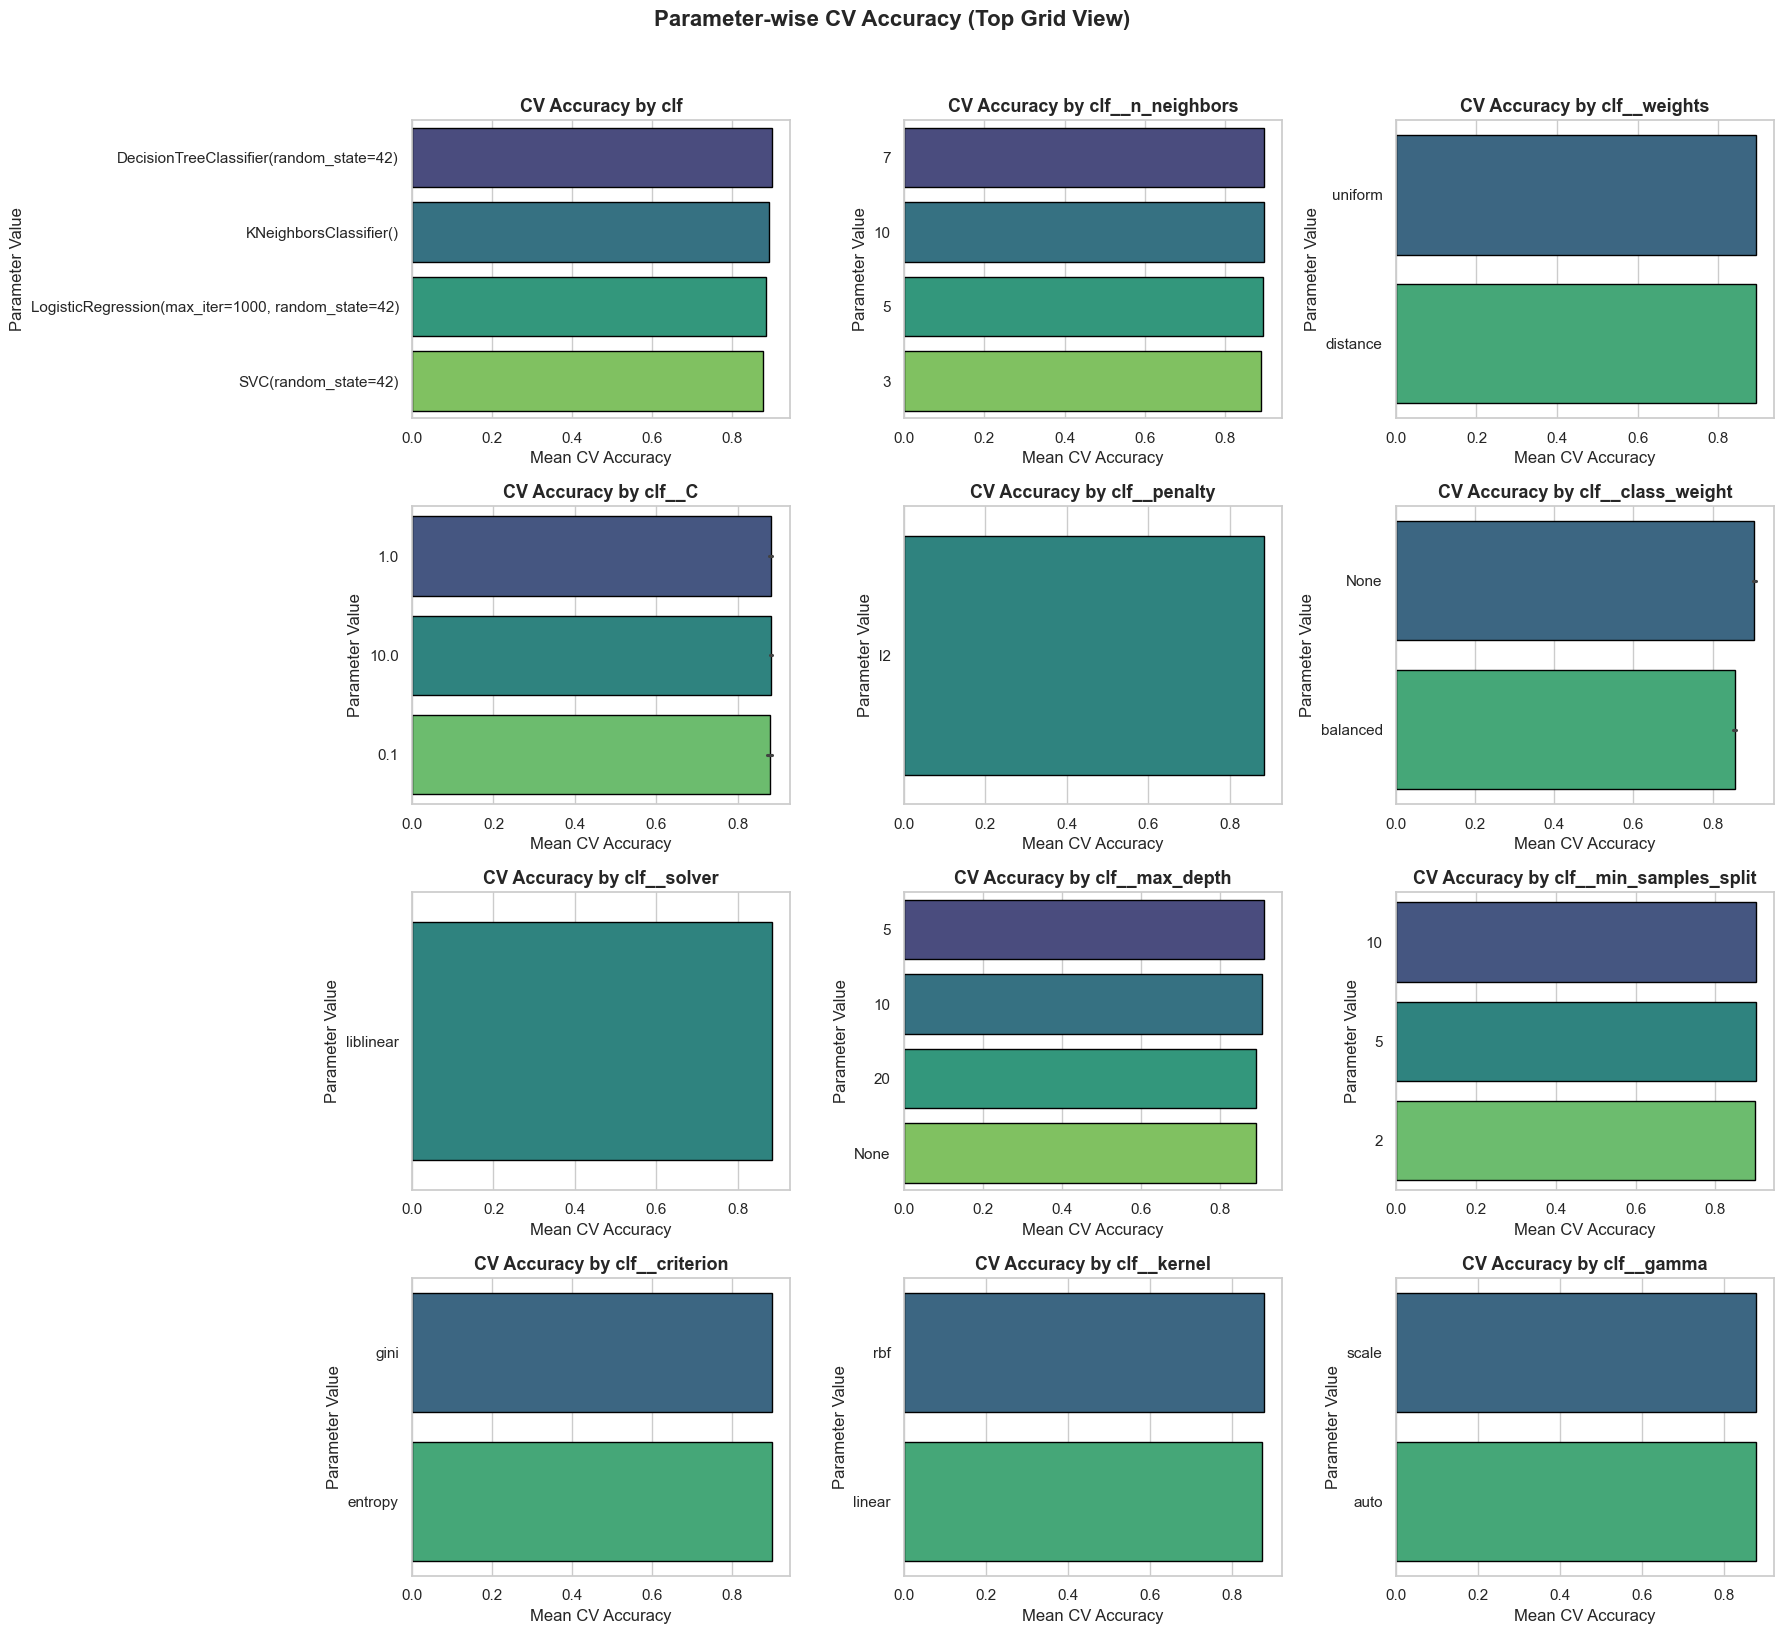

In [44]:

param_perf_df['Value'] = param_perf_df['Value'].astype(str)
param_perf_df['Parameter'] = param_perf_df['Parameter'].astype(str)
unique_params = param_perf_df['Parameter'].unique()
n_params = len(unique_params)

print('\n' + '='*100)
print('Section: Model Parameter-wise Behaviour ')
print('='*100 + '\n')

n_cols = 3
n_rows = math.ceil(n_params / n_cols)


sns.set(style='whitegrid')
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=False)
axes = axes.flatten()  # Flatten for easy iteration


# Plot each parameter
for i, param in enumerate(unique_params):
    ax = axes[i]
    data = param_perf_df[param_perf_df['Parameter'] == param].sort_values(by='Mean CV Accuracy', ascending=False)
    sns.barplot(
        data=data,
        x='Mean CV Accuracy',
        y='Value',
        ax=ax,
        palette='viridis',
        edgecolor='black',hue='Value'
    )
    ax.set_title(f'CV Accuracy by {param}', fontsize=13, fontweight='bold')
    ax.set_xlabel('Mean CV Accuracy')
    ax.set_ylabel('Parameter Value')


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Parameter-wise CV Accuracy (Top Grid View)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
print('\n' + '='*100)


Section: Model Parameter-wise Behaviour by Recall



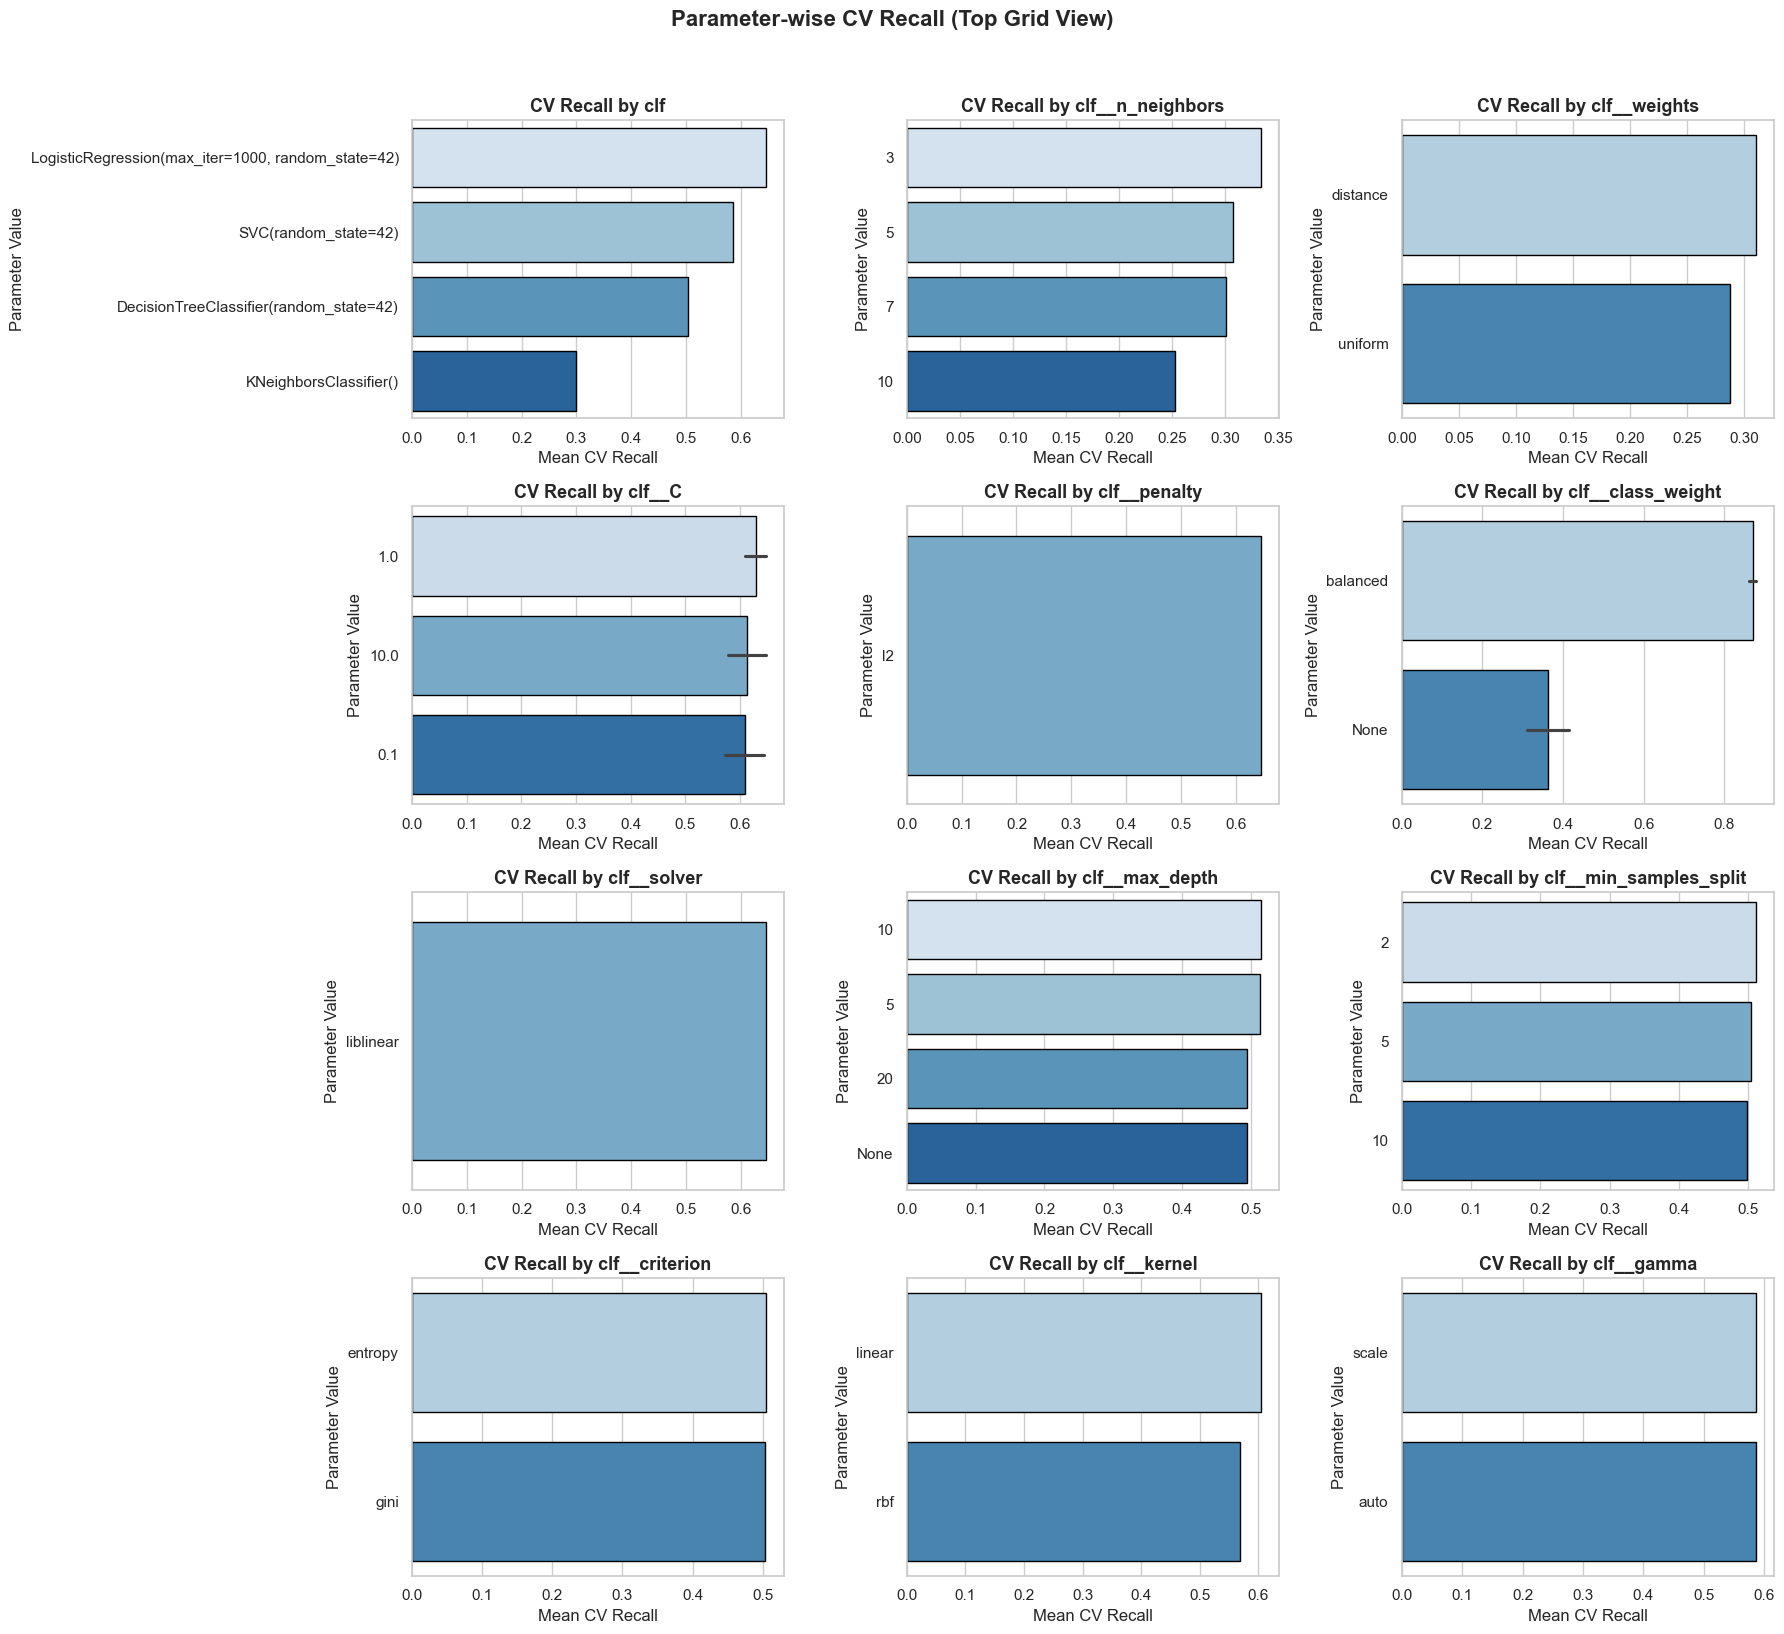

In [45]:
# === Recall plots ===
print('\n' + '='*100)
print('Section: Model Parameter-wise Behaviour by Recall')
print('='*100 + '\n')

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=False)
axes = axes.flatten()

for i, param in enumerate(unique_params):
    ax = axes[i]
    data = param_perf_df[param_perf_df['Parameter'] == param].sort_values(by='Mean CV Recall', ascending=False)
    sns.barplot(
        data=data,
        x='Mean CV Recall',
        y='Value',
        ax=ax,
        palette='Blues',
        edgecolor='black',
        hue='Value'
    )
    ax.set_title(f'CV Recall by {param}', fontsize=13, fontweight='bold')
    ax.set_xlabel('Mean CV Recall')
    ax.set_ylabel('Parameter Value')

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Parameter-wise CV Recall (Top Grid View)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


Section: Model Cross-Validation



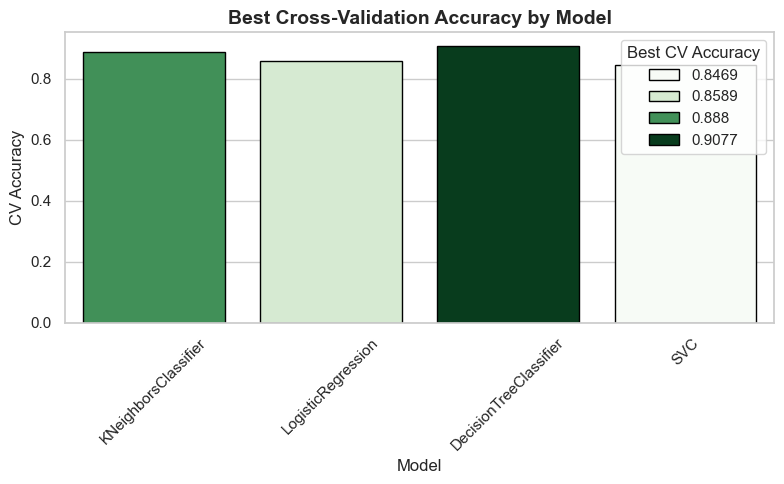


Section: Model Test Accuracy 



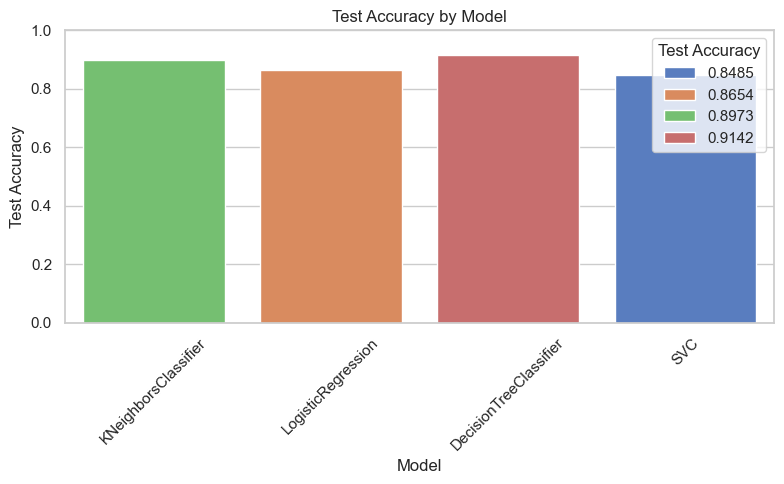


Section: Model Test Recall 



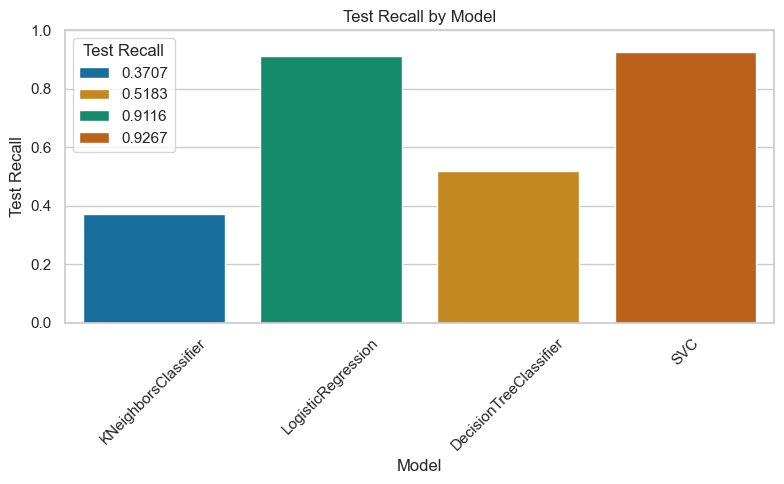


Section: Model Training Time 



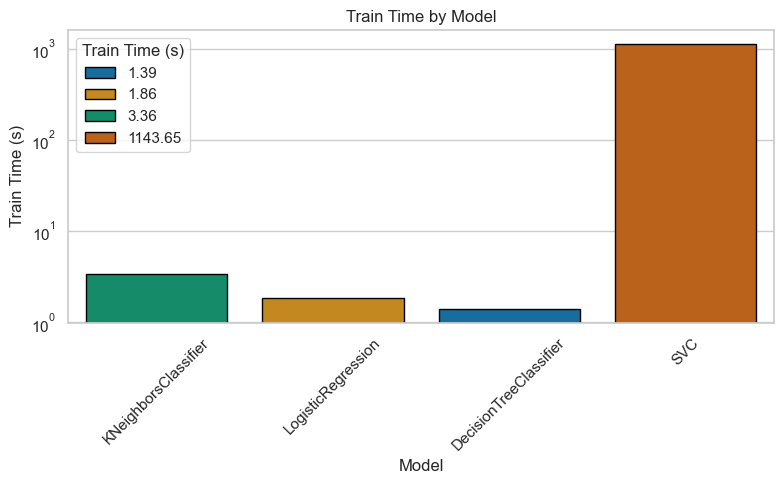

In [46]:
print('\n' + '='*100)
print('Section: Model Cross-Validation')
print('='*100 + '\n')

# Plot model-level comparison
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Model', y='Best CV Accuracy', palette='Greens', edgecolor='black' ,hue='Best CV Accuracy')
plt.title('Best Cross-Validation Accuracy by Model', fontsize=14, fontweight='bold')
plt.ylabel('CV Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print('\n' + '='*100)
print('Section: Model Test Accuracy ')
print('='*100 + '\n')

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Model', y='Test Accuracy', palette='muted',hue='Test Accuracy')
plt.title('Test Accuracy by Model')
plt.ylim(0, 1)
plt.ylabel('Test Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print('\n' + '='*100)
print('Section: Model Test Recall ')
print('='*100 + '\n')
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Model', y='Test Recall', palette='colorblind',hue='Test Recall' )
plt.title('Test Recall by Model')
plt.ylim(0, 1)
plt.ylabel('Test Recall')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



print('\n' + '='*100)
print('Section: Model Training Time ')
print('='*100 + '\n')

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Model', y='Train Time (s)', palette='colorblind',hue='Train Time (s)',edgecolor='black')
plt.title('Train Time by Model')
plt.ylabel('Train Time (s)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print('='*100 + '\n')

In [47]:
pd.set_option('display.max_colwidth', None)  
results_df

,Model,Train Time (s),Train Accuracy,Test Accuracy,Train Recall,Test Recall,Best Params,Best CV Accuracy,Best CV Recall
0,KNeighborsClassifier,3.36,1.0000,0.8973,1.0000,0.3707,"{'clf': KNeighborsClassifier(), 'clf__n_neighbors': 3, 'clf__weights': 'distance'}",0.8880,0.3384
1,LogisticRegression,1.86,0.8592,0.8654,0.8855,0.9116,"{'clf': LogisticRegression(max_iter=1000, random_state=42), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}",0.8589,0.8790
2,DecisionTreeClassifier,1.39,0.9374,0.9142,0.6307,0.5183,"{'clf': DecisionTreeClassifier(random_state=42), 'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_split': 2}",0.9077,0.5213
3,SVC,1143.65,0.8475,0.8485,0.9119,0.9267,"{'clf': SVC(random_state=42), 'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale', 'clf__kernel': 'linear'}",0.8469,0.9089


In [48]:
param_perf_df

,Model,Parameter,Value,Mean CV Accuracy,Mean CV Recall
0,KNeighborsClassifier,clf,KNeighborsClassifier(),0.8935,0.2987
1,KNeighborsClassifier,clf__n_neighbors,3,0.8889,0.3339
2,KNeighborsClassifier,clf__n_neighbors,5,0.8930,0.3072
3,KNeighborsClassifier,clf__n_neighbors,7,0.8962,0.3005
4,KNeighborsClassifier,clf__n_neighbors,10,0.8958,0.2531
5,KNeighborsClassifier,clf__weights,uniform,0.8940,0.2870
6,KNeighborsClassifier,clf__weights,distance,0.8930,0.3103
7,LogisticRegression,clf,"LogisticRegression(max_iter=1000, random_state=42)",0.8841,0.6468
8,LogisticRegression,clf__C,0.1,0.8839,0.6441
9,LogisticRegression,clf__C,1.0,0.8843,0.6483


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [49]:
# Fine tuning Logistic Regression for best param 
# {'clf': LogisticRegression(max_iter=1000, random_state=42), 
# 'clf__C': 10, 'clf__class_weight': 'balanced', 
# 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}

# Evaluating if changing default prediction probability of 0.5 helps 

pipelr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        max_iter=1000,
        random_state=42,
        C=10,
        class_weight='balanced',
        penalty='l2',
        solver='liblinear'
    ))
])

# Fit the model
pipe.fit(X_train, y_train)

# Predict probabilities on test set
y_proba = pipe.predict_proba(X_test)[:, 1]

# Evaluate at different thresholds
thresholds = [0.5, 0.4, 0.3, 0.25, 0.2]

print("Performance at different thresholds:\n")
for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    
    recall = recall_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh)
    accuracy = accuracy_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)

    print(f"Threshold: {thresh:.2f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print("-" * 40)


Performance at different thresholds:

Threshold: 0.50
  Recall:    0.3448
  Precision: 0.6178
  Accuracy:  0.9022
  F1 Score:  0.4426
----------------------------------------
Threshold: 0.40
  Recall:    0.5582
  Precision: 0.5139
  Accuracy:  0.8908
  F1 Score:  0.5351
----------------------------------------
Threshold: 0.30
  Recall:    0.5582
  Precision: 0.5139
  Accuracy:  0.8908
  F1 Score:  0.5351
----------------------------------------
Threshold: 0.25
  Recall:    0.5582
  Precision: 0.5139
  Accuracy:  0.8908
  F1 Score:  0.5351
----------------------------------------
Threshold: 0.20
  Recall:    0.7920
  Precision: 0.3457
  Accuracy:  0.8077
  F1 Score:  0.4813
----------------------------------------


In [67]:
X = X_final
y = y_encoded

 
thresholds = [0.5, 0.4, 0.3, 0.25, 0.2]

 
results = {t: [] for t in thresholds}

 
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')


kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    knn.fit(X_train, y_train)
    y_proba = knn.predict_proba(X_val)[:, 1]

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        recall = recall_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)

        results[t].append({
            'Recall': recall,
            'Precision': precision,
            'Accuracy': acc,
            'F1': f1
        })

print("\nCross-Validation Results by Threshold:\n")
for t in thresholds:
    recalls = [r['Recall'] for r in results[t]]
    precisions = [r['Precision'] for r in results[t]]
    accs = [r['Accuracy'] for r in results[t]]
    f1s = [r['F1'] for r in results[t]]
    
    print(f"Threshold: {t:.2f}")
    print(f"  Avg Recall:    {np.mean(recalls):.4f}")
    print(f"  Avg Precision: {np.mean(precisions):.4f}")
    print(f"  Avg Accuracy:  {np.mean(accs):.4f}")
    print(f"  Avg F1 Score:  {np.mean(f1s):.4f}")
    print("-" * 40)



Cross-Validation Results by Threshold:

Threshold: 0.50
  Avg Recall:    0.4760
  Avg Precision: 0.5833
  Avg Accuracy:  0.9027
  Avg F1 Score:  0.5241
----------------------------------------
Threshold: 0.40
  Avg Recall:    0.5795
  Avg Precision: 0.5457
  Avg Accuracy:  0.8983
  Avg F1 Score:  0.5620
----------------------------------------
Threshold: 0.30
  Avg Recall:    0.6867
  Avg Precision: 0.5149
  Avg Accuracy:  0.8918
  Avg F1 Score:  0.5884
----------------------------------------
Threshold: 0.25
  Avg Recall:    0.7099
  Avg Precision: 0.5004
  Avg Accuracy:  0.8875
  Avg F1 Score:  0.5869
----------------------------------------
Threshold: 0.20
  Avg Recall:    0.7581
  Avg Precision: 0.4556
  Avg Accuracy:  0.8707
  Avg F1 Score:  0.5691
----------------------------------------


##### Questions